In [102]:
import numpy as np
import pandas as pd
import math
import operator
import matplotlib.pyplot as plt
import pprint

In [350]:
def get_test_train(location):
    location = '~/Documents/SMAI/Assignment2/' + location
    dataframe = pd.read_csv(location,header=None)
    dataframe = dataframe.sample(frac=1).reset_index(drop=True)
    train  = dataframe[:int(0.8*len(dataframe))]
    test = dataframe[int(0.8*len(dataframe)):]
    return test,train

In [285]:
def get_test_train_with_header(location):
    location = '~/Documents/SMAI/Assignment2/' + location
    dataframe = pd.read_csv(location)
    dataframe = dataframe.sample(frac=1).reset_index(drop=True)
    train  = dataframe[:int(0.8*len(dataframe))]
    test = dataframe[int(0.8*len(dataframe)):]
    return test,train

##  I. K- Nearest Neighbour (KNN)
KNN is one of the most simplest to implement algorithms in Machine Learning. It deals with calculating       distance (of a new data point) with respect to all other data points and finds K nearest neighbout to classify in of the labels.

An advantage of KNN is that there is no actual training done unlike other machine learning algorithms. More details mentioned in the algorithm below.

### Algorithm
1. For every new data point, find the distance between each anad every other already existing data points and    store in a list. The distance can be found by minkowski measure which is discussed in the next segment.<br><br>

2. Once distance of a data point from all other data points is found, find those 'K' elements which are          nearest to the data point in question. This can be found by sorting the list of distances. The most            efficient way to sort is using a heap. For simplicity we have used a list.<br><br>

3. Among the 'K' nearest points, find the most frequently occuring label and classify the unknown data point      to that label.

The below function <b>KNN()</b> does the above mentioned steps. 

### Minkowski Distance

The minkowski distance is of the form : $\sum_{i \in R}|x_i - t_i|^{p}$ where <b>R</b> is a row which represents a data point and <b>i</b> is each field in the row, <b>x</b> is an already data point and <b>t</b> is a new data point to be classified.

It is important to note that Minkowski is a generalized distnace formula.The value <b>p</b> defines which distance is used. when <b>p</b> equals 1, it is known as <b>Euclidian Distance</b>.

When <b>p</b> equals 2, it is known as <b>Manhattan distance</b>. We have used only these two measures however there are many more distnace metrics out of the Minkowski distance. <b>minkowski_predict</b> calculates the above expression

In [342]:
'''
USED IN KNN
'''
def minkowski_predict(test_row,train_row,power,target):
    dist = 0
    for attribute in range(0,len(test_row)):
        if attribute != target:
            dist+=(pow(abs(test_row[attribute] - train_row[attribute]),power))
    return pow(dist,1/power)

In [106]:
'''
USED IN KNN
'''
def getsecond(item):
    return item[1]


def KNN(test,train,K,dist_measure,target):
    unique_values = np.unique(train.values[:,target])
    maxval = -1
    winner = None
    class_dict = {}
    for classVal in unique_values:
        class_dict[classVal] = 0
  
    if dist_measure == 'euclid':
        power = 2
    elif dist_measure == 'man':
        power = 1
    predicted = []
    for test_row in test.values:
        #print(test_row)
        knn = []
        maxval = -1
        winner = None
        for train_row in train.values:
            #print(train_row)
            #print(test_row)
            y = minkowski_predict(test_row,train_row,power,target)
            #print(y)
            knn.append((train_row[target],y))
        knn.sort(key = getsecond)
        
        #print(knn)
        for i in range(0,K):
            class_dict[knn[i][0]]+=1
            #if class_dict[knn[i][0]] > maxval:
            #    winner = knn[i][0]
            #    maxval = class_dict[knn[i][0]]
        winner = max(class_dict.items(),key=operator.itemgetter(1))[0]    
        predicted.append(winner)
        #print(class_dict)
        for classVal in unique_values:
            class_dict[classVal] = 0
    return predicted        

## II. Naive Bayes

Naive Bayes algorithm is a classifier like KNN but uses bayes theorem for classification.

Naive bayes theroem states that the probablity of an event A given an occured event B is the product of the probability of event A and the probability of other events given A has occured. The above can be formulated like this: $P(A|B) = \dfrac{P(A)P(B|A)}{P(B)}$

Here, we will treat features that are categorical and continuous differently. For the features that are categorical we will find the probability of a label(class) within different categories of a feature.
For numeric columns we will use Gaussian Naive Bayes which requires the mean and variance of the feature.

<b>Gaussian Naive Bayes</b> : $P(x|y) = \dfrac{1}{\sqrt{2\pi\sigma_y^{2}}}\exp\Bigg({\dfrac{-(x-\mu_y)^2}{2\sigma_y^2}}\Bigg)$ <br>
where $\mu_y$ is the mean of the exisiting values of the feature and $\sigma_y$ is the variance of the same $x$ is the value whose probability is to be found. <br>

### Algorithm

1. From each feature that is categorical, for each category in it, find the probability of the occurance each label (example: Probability of playing(target) is 'Yes'(label) given temperature(feature) is 'Hot'(category) ). By this we calculate the likelihood.

2. For every numerical feature, we calculate the mean and the variance which will be useful in calculating the gaussian distribution of the unknown value later.

3. Once the model is created using ideas meantioned above, we ue this model to predict the posterior probability using the prior and likelihood for categorical features, gaussian distribution for continuous variables. 

The function <b>NaiveBayes()</b> does the modeling from the given data.
The function <b>NaivePredict()</b> is used for predicting probability.

In [74]:
'''
USED IN NAIVE BAYES
'''
def NaivePredict(NaiveModel,test,train,target,catcolumns):
    size = train.shape[0]  
    class_count = {}
    unique_classes = np.unique(train.values[:,target])
    for classes in unique_classes:
        class_count[classes] = 0 
        
    for i in train.values[:,target]:
        class_count[i]+=1/size
    result= 1
    column_pos=1
    largest=-1
    class_lab = None
    predicted_y = []
    #print(train)
    #print(test)
    for row in test.values:
        #print(row)
        for key in NaiveModel:
            while column_pos < row.shape[0]:
                if column_pos!=target:
                    if column_pos in catcolumns:
                        result *= NaiveModel[key][column_pos][row[column_pos]] 
                    else:
                        #print(key,column_pos,NaiveModel[key][column_pos])
                        mean = NaiveModel[key][column_pos]['mean']
                        var = NaiveModel[key][column_pos]['var']
                        distribution = 1/(np.sqrt(2*np.pi*var)) * np.exp((-(row[column_pos]-mean)**2)/(2*var))
                        result*=distribution
                else:
                    column_pos+=1 
                    continue
                column_pos+=1    
            
            result*=class_count[key]
            column_pos = 1
            if result > largest:
                largest = result
                class_lab = key
            result=1    
        
        predicted_y.append(class_lab)
        largest=-1
        class_lab=None
    #print(predicted_y)
    a,p,r,f = BinaryMeasure(predicted_y,test,target)
    return a,p,r,f
                        

In [112]:
'''
USED IN NAIVE BAYES
'''

def NaiveBayes(train,target,catcolumns):
    #get a count of classes in target variable
    unique_classes = np.unique(train.values[:,target])
    size = train.shape[0]
    class_dict = {}
  
    for classes in unique_classes:
        class_dict[classes] = {}    #For probability
        
    column_pos = 1  
    noofcolumns = train.values.shape[1] 
    while column_pos < noofcolumns:
        attribute = train.values[:,column_pos]
        for key in class_dict:
            class_dict[key][column_pos] = {}
            filtered_mat = train.values[(train.values[:,target] == key),:]
            key_size = filtered_mat.shape[0]
            if column_pos in catcolumns:
                unique_category = np.unique(attribute)
                for category in unique_category:
                    class_dict[key][column_pos][category] = 0
                    filtered_mat = (train.values[:,column_pos] == category) & (train.values[:,target] == key)
                    filtered_mat = train.values[filtered_mat,:]
                    class_dict[key][column_pos][category] = filtered_mat.shape[0]/key_size
            elif column_pos!=target:
                mean = filtered_mat[:,column_pos].mean(axis=0)
                var = filtered_mat[:,column_pos].var(axis=0)
                class_dict[key][column_pos]['mean'] = mean
                class_dict[key][column_pos]['var'] = var
        column_pos+=1
    return class_dict    
    #pprint.pprint(class_dict)        
                    
                

## III. Linear Regression

Linear regression is one of the most widely used and easy to implement regression techniques. A regression technique such as linear regression is not used to classify but directly predict a value for given features.

### Algorithm

1. Initially, random slopes with respect to number of features is considered. It could be any number.<br><br>

2. Another matrix is considered which is the collection of features and it's values. This, with the slopes above tells you about a random line on a 2D plane. We have to use this line and the data pints in the data space to fit the line in such a away that it passes through the mean of all the points.<br><br>

3. There are error methods like Mean Squared error, Mean Absolute Error and Mean Absolute Percentage Error which are used to calculate the distance between out predicted point to the actual point.<br><br>

4. Using gradient descent, we can minimize the error such that our slope fits in the mean of our data.
   We continur this until our error funcion hits a minima.<br><br>

5. Now we can use R2 score to predict our accuracy. 

Formula for each functionalities is meentioned below.

### R2 score

$R2_{Score}(Y_{pred},Y_{true}) = 1 - \Bigg(\dfrac{\sum{(Y_{true} - mean(Y_{true}))^2}}{\sum{(Y_{true} - Y_{pred})^2}} \Bigg)$

where $Y_{true}$ is the true target values,<br>
$mean(T_{true})$ is the mean of the true values,<br>
$Y_{pred}$ is the predicted target value.

In [150]:
'''
USED IN LINEAR REGRESSION
'''
def r2_score(Y, Y_pred):
    mean_y = np.mean(Y)
    tot = sum((Y - mean_y) ** 2)
    res = sum((Y - Y_pred) ** 2)
    r2 = 1 - (res / tot)
    return r2

### Mean Squared Error

$Cost(B) = \dfrac{1}{2m}\sum{(\beta^TX - Y)^2}$

Where $\beta$ is the vector of slopes,<br>
$Y$ is the predicted value,<br>
$m$ is the total number of samples

In [151]:
'''
USED IN LINEAR REGRESSION
'''
def MeanSquaredError(X,B,Y):
    m = X.shape[0]
    cost = (1/(2*m))*np.sum((X.dot(B) - Y)**2)
    return(cost)

### Mean Absolute Error

$Cost(B) = \dfrac{1}{m}\sum{|\beta^TX - Y|}$

Where $\beta$ is the vector of slopes,<br>
$Y$ is the predicted value,<br>
$m$ is the total number of samples

In [152]:
'''
USED IN LINEAR REGRESSION
'''
def MeanAbsoluteError(X,B,Y):
    m = X.shape[0]
    cost = (1/m)*np.sum(np.abs(X.dot(B) - Y))
    return(cost)

### Mean Absolute Percentage Error

$Cost(B) = \dfrac{1}{m}\sum{\dfrac{|\beta^TX - Y|}{|\beta^TX|}}\ast 100$<br><br>
Where $\beta$ is the vector of slopes,<br>
$Y$ is the predicted value,<br>
$m$ is the total number of samples

In [153]:
'''
USED IN LINEAR REGRESSION
'''
def MeanAbsolutePercentage(X,B,Y):
    m = X.shape[0]
    cost = (1/m)*np.sum(np.abs((X.dot(B) - Y))/(X.dot(B)))*100
    return(cost)

### Gradient Descent

$\beta_i = \beta_i - \alpha\ast\dfrac{1}{m}\sum_{m \in M}(\beta_i^TX_m - Y)X_i $ <br>

where $X_i$ is the gradient, $\beta_i^TX$ is the hypothesis, $Y$ is the true value and $\beta_i$ is the slope of the $i^{th}$ feature. This step updates the slope by calculating the new slope by minimizing cost by differentiating one of the cost functions above. 

In [154]:
'''
USED IN LINEAR REGRESSION
'''
def gradient_descent(X,B,Y,alpha):
    m = len(Y)
    cost = 0
    for i in range(10000):
        #print(B)
        B -= alpha*(1/m)*(X.T.dot((X.dot(B) - Y)))
        cost = cost_function(X,B,Y)
        #print(cost)
    return B,cost

In [155]:
'''
USED IN LINEAR REGRESSION
'''
def predictLinear(test,target,B):
    X = []
    x0 = np.ones(test.shape[0])
    columns = list(test.columns)
    columns.pop(0)
    X.append(list(x0))
    for col in columns:
        if col!= target:
            #print(col)
            normalized_col = list(((test[col].values) - np.mean(test[col].values))/np.std(test[col].values))
            X.append(normalized_col)
    
    X = np.array(X).T
    Y = np.array(test[target].values)
    predicted_y = X.dot(B)
    r2score = r2_score(Y,predicted_y)
    return X,predicted_y,r2score

In [311]:
'''
USED IN LINEAR REGRESSION
'''
def LinearRegressionFit(test,train,target):
    #get X matrx which consists all features
    X = []
    x0 = np.ones(train.shape[0])
    columns = list(train.columns)
    columns.pop(0)
    X.append(list(x0))
    for col in columns:
        if col!= target:
            #print(col)
            normalized_col = list(((train[col].values) - np.mean(train[col].values))/np.std(train[col].values))
            X.append(normalized_col)
    
    X = np.array(X).T
    #X = np.array(X)
    B = np.array(np.zeros(len(columns)))
    Y = np.array(train[target].values)
    alpha = 0.01
    #B = Y.T.dot(np.linalg.inv(X.T.dot(X)).dot(X.T))
    B,cost = gradient_descent(X,B,Y,alpha)
    return(B)
  

### Prediction (Binary label)

The function <b>BinaryMeasure()</b> is the function that <b>predicts</b> the value for a test set. 

#### Formula to calculate Accuracy, Precision, Recall and F-Score:

<b>Accuracy</b> = $\dfrac{TP + TN}{TP+TN+FP+FN}$ <br><br>
<b>Precision</b> = $\dfrac{TP}{TP+FP}$<br><br>
<b>Recall</b> = $\dfrac{TP}{TP+FN}$<br><br>
<b>F-Score</b> = $\dfrac{2}{(\dfrac{1}{Recall}+\dfrac{1}{Precision})}$<br><br>

where <b>TP</b> = True Positive,<br><b>TN</b> = True Negative,<br><b>FP</b> = False Positive,<br><b>FN</b> = False Negative
     

In [157]:
def BinaryMeasure(predicted_y,test,target):
    j = 0
    TN=0
    TP=0
    FN=0
    FP=0
    for i in predicted_y:
        if i==0 and i == (test.values)[j][target]:
            TN+=1
        elif i==0 and i!= (test.values)[j][target]:
            FN+=1
        elif i==1 and i == (test.values)[j][target]:
            TP+=1
        elif i==1 and i!= (test.values)[j][target]:
            FP+=1
        j+=1
        
    accuracy =  (TP+TN)/(TP+TN+FP+FN)
    precision = (TP)/(TP+FP)
    recall = (TP)/(TP+FN)
    fscore = 2/((1/precision)+(1/recall))
    return accuracy,precision,recall,fscore

### Prediction (Multiclass label)
<br>
<b>Accuracy</b> = $\dfrac{TP + TN}{TP+TN+FP+FN}$ <br><br>
<b>Precision</b> = $\dfrac{1}{N}\sum_{c \in class}freq_{c}\ast\dfrac{TP_c}{TP_c+FP_{c}}$<br><br>
<b>Recall</b> = $\dfrac{1}{N}\sum_{c \in class}freq_{c}\ast\dfrac{TP_c}{TP_c+FN_{c}}$<br><br>
<b>F-Score</b> = $\dfrac{1}{N}\sum_{c \in class}freq_{c}\ast\dfrac{2}{\dfrac{1}{precision_{c}}+\dfrac{1}{recall_{c}}}$<br><br>

where <b>c</b> is some class which is considered as <b>True</b> value and other classes is considered as <b>False</b>,<br><b>N</b> is the total number of samples,<br>
<b>TP</b> = True Positive,<br><b>TN</b> = True Negative,<br><b>FP</b> = False Positive,<br><b>FN</b> = False Negative<br>
The function <b>MultipleMeasure()</b> does the above mentioned task.

In [84]:
def MultipleMeasure(predicted_y,test,train,target):
    j=0
    unique_classes = np.unique(train.values[:,target])
    accuracy = 0
    precision = 0
    recall = 0
    fscore = 0

    class_dict = {}
    for lclass in unique_classes:
        class_dict[lclass] = 0
   
    for i in (test.values)[:,target]:
        class_dict[i]+=1
        j+=1
    j=0
    
    size = test.shape[0]
    
    for lclass in unique_classes:
        TN=0
        TP=0
        FN=0
        FP=0
        freq = class_dict[lclass]
        for i in predicted_y:
            if lclass == (test.values)[j][target] and i==lclass: 
                TP+=1
            elif lclass!= (test.values)[j][target] and i==lclass:
                FP+=1
            elif lclass!= (test.values)[j][target] and i!=lclass:
                TN+=1
            elif lclass == (test.values)[j][target] and i!=lclass:
                FN+=1
            j+=1
        j=0    

        accuracy +=  (freq/size)*((TP+TN)/(TP+TN+FP+FN))
        precision += (freq/size)*((TP)/(TP+FP))
        recall += (freq/size)*((TP)/(TP+FN))
        fscore += (freq/size)*(2/((1/precision)+(1/recall)))
    return accuracy,precision,recall,fscore

## Question - 1
### A. Datasets -- Robot1 and Robot2

### 1. Implement a KNN classifier for each of the datasets. Report precision, recall, f1 score and accuracy. Compare your result with in-built(scikit-learn) KNN function to check correctness of your algorithm.

In [343]:
#Robot1
location = 'RobotDataset/Robot1'
test,train = get_test_train(location)
test = pd.DataFrame(np.delete(test.values,7,1))
train = pd.DataFrame(np.delete(train.values,7,1))
K = 7
target = 0
predicted_y = KNN(test,train,K,'euclid',target)
accuracy,precision,recall,fscore = BinaryMeasure(predicted_y,test,target)
print("Robot1")
print("===================================")
print("Accuracy = ",accuracy)
print("Precision = ",precision)
print("Recall = ",recall)
print("fscore = ",fscore)

print("\n")

#Robot2
location = 'RobotDataset/Robot2'
test,train = get_test_train(location)
test = pd.DataFrame(np.delete(test.values,7,1))
train = pd.DataFrame(np.delete(train.values,7,1))
K = 7
target = 0
predicted_y = KNN(test,train,K,'euclid',target)
accuracy,precision,recall,fscore = BinaryMeasure(predicted_y,test,target)
print("Robot2")
print("===================================")
print("Accuracy = ",accuracy)
print("Precision = ",precision)
print("Recall = ",recall)
print("fscore = ",fscore)

print("\n")

#Iris
location = 'Iris/Iris.csv'
test,train = get_test_train(location)
K = 7
target = 4
predicted_y = KNN(test,train,K,'euclid',target)
accuracy,precision,recall,fscore = MultipleMeasure(predicted_y,test,train,target)
print("Iris")
print("===================================")
print("Accuracy = ",accuracy)
print("Precision = ",precision)
print("Recall = ",recall)
print("fscore = ",fscore)


Robot1
Accuracy =  0.84
Precision =  0.8181818181818182
Recall =  0.8181818181818182
fscore =  0.8181818181818182


Robot2
Accuracy =  0.96
Precision =  1.0
Recall =  0.9285714285714286
fscore =  0.9629629629629631


Iris
Accuracy =  0.9753086419753086
Precision =  0.9675925925925926
Recall =  0.962962962962963
fscore =  0.655412105896163


### 2. Use different distance measures as applicable. Plot graph to report accuracy with change in value of K. Also suggest possible reason for better performance.

In [344]:
def gen_KNN_plot(test,train,target,binary):
    distanceMeasures = ['euclid','man'] 
    accuracy_array1 = []
    accuracy_array2 = []
    for dist_measure in distanceMeasures:
        K = 1
        K_array = []
        accuracy_array2 = []
        while K<= math.sqrt(len(train)):
            predicted_y = KNN(test,train,K,dist_measure,target)
            if binary == 1:
                accuracy,precision,recall,fscore = BinaryMeasure(predicted_y,test,target)
            elif binary == 0:
                accuracy,precision,recall,fscore = MultipleMeasure(predicted_y,test,train,target)
            K_array.append(K)
            accuracy_array2.append(accuracy)
            K+=2
        if dist_measure == 'euclid':    
            accuracy_array1 = accuracy_array2.copy()    
    plt.plot(K_array,accuracy_array1,c='b',label = 'euclid')
    plt.xlabel("K Value")
    plt.ylabel("Accuracy")
    plt.plot(K_array,accuracy_array2,c='r',label = 'manhattan')
    plt.legend()
    plt.show()


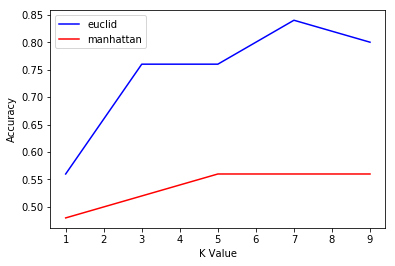

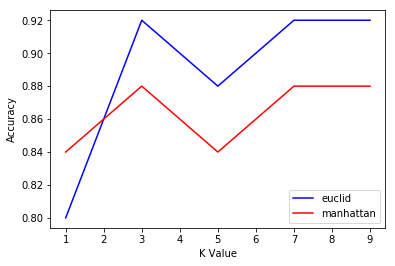

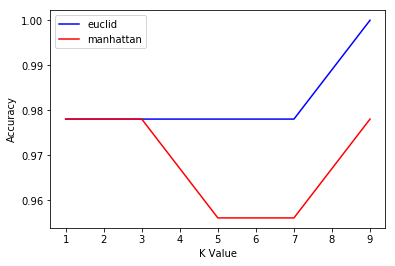

In [349]:
location = 'RobotDataset/Robot1'
test,train = get_test_train(location)
test = pd.DataFrame(np.delete(test.values,7,1))
train = pd.DataFrame(np.delete(train.values,7,1))
target=0
binary = 1
gen_KNN_plot(test,train,target,binary)

location = 'RobotDataset/Robot2'
test,train = get_test_train(location)
test = pd.DataFrame(np.delete(test.values,7,1))
train = pd.DataFrame(np.delete(train.values,7,1))
target=0
binary=1
gen_KNN_plot(test,train,target,binary)

location = 'Iris/Iris.csv'
test,train = get_test_train(location)
target = 4
binary=0
gen_KNN_plot(test,train,target,binary)

As can be seen from the above graph, there are particular values of K which gives a peak in accuracy. 
The graph is not a monotonous one. Extreme low values of K can give you a bad accuracy and also too high value of K can give you a bad accuracy. 

In case of different distance measures, we calculate the distance using Minkowski distance. Different values of p results in a different distance function(p=1 gives Manhattan and p=2 gives us Euclidian). 

## Question - 2
### A bank is implementing a system to identify potential customers who have higher probablity of availing loans to increase its profit. Implement Naive Bayes classifier on this dataset to help bank achieve its goal. Report your observations and accuracy of the model.

In [339]:
location = 'LoanDataset/data.csv'
test,train = get_test_train(location)
catcolumns = [7,10,11,12,13]
target = 9
NaiveModel = NaiveBayes(train,target,catcolumns)
accuracy,precision,recall,fscore = NaivePredict(NaiveModel,test,train,target,catcolumns)
print("Accuracy : ",accuracy)

Accuracy :  0.9188888888888889


As per the observation feature which has low number of categories and the values in test are made to be sure to belong to those categories every time, then it is safe to consider that as a categorical feature.

Whereas an attribute like 'Family Size' which can be considered as a categorical data since on an average family size is between 3 to 5. But turns out this will give a bad accuracy as a categorical feature since in test family size may not always belong to 3-5 like the above case.

## Question - 3
### 3.1 Implement a model using linear regression to predict the probablity of getting the admit.

In [358]:
#location = '~/Documents/SMAI/Assignment2/AdmissionDataset/data.csv'
location = 'AdmissionDataset/data.csv'
test,train = get_test_train_with_header(location)
target = 'Chance of Admit'
slopeValues = LinearRegressionFit(test,train,target)
#print(slopeValues)
X,predicted_y,r2score = predictLinear(test,target,slopeValues)
print("R-2 Score : ",r2score)

R-2 Score :  0.8540897784460632


### 3.2 Compare the performance of Mean square error loss function vs Mean Absolute error function vs Mean absolute percentage error function and explain the reasons for the observed behaviour.

In [288]:
location = 'AdmissionDataset/data.csv'
test,train = get_test_train_with_header(location)
target = 'Chance of Admit'
slopeValues = LinearRegressionFit(test,train,target)
#print(slopeValues)
X,predicted_y,r2score = predictLinear(test,target,slopeValues)
#Mean Square Error Loss Function
print("Mean Squared Error: ",MeanSquaredError(X,slopeValues,np.array(test[target].values)))
#Mean Absolute Error
print("Mean Absolute Error: ",MeanAbsoluteError(X,slopeValues,np.array(test[target].values)))
#Mean Absolute percentage
print("Mean Absolute Percentage Error: ",MeanAbsolutePercentage(X,slopeValues,np.array(test[target].values)),"%")

Mean Squared Error:  0.0030288607012191188
Mean Absolute Error:  0.05667520322539227
Mean Absolute Percentage Error:  7.931059106880069 %


### 3.3 Analyse and report the behaviour of the coefficients(for example: sign of coefficients, value of coefficients etc.) and support it with appropriate plots as necessary

In [290]:
location = 'AdmissionDataset/data.csv'
test,train = get_test_train_with_header(location)
target = 'Chance of Admit'
slopeValues = LinearRegressionFit(test,train,target)
print("Coefficients: \n")
print(slopeValues)

Coefficients: 

[ 0.72091667  0.02170602  0.01809302  0.01128675 -0.00166988  0.01129876
  0.06480923  0.01291693]


A coefficient 'm' is known as the slope of a line or a plane or any other geometeric shape.
It tells how much an dependent variable 'rises' with respect to 'run' of an independent variable .

<b>Example:</b> Consider an equation of the line <b>y = mx + c</b>. Here, y is the dependent variable and x is the indpendent variable and m is the slope. 

As seen above, the 'y' intercept here is the first value in the list meaning the plane intersects at y-axis at point that point. The rest are the slopes for each features (thus forming a hyperplane).

A positive coefficient means the slope is ascending (think linearly increasing line).

A negative coefficient means the slope is descending (think linearly decreasing line).

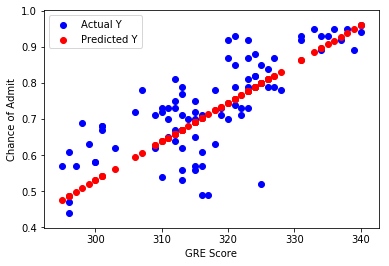

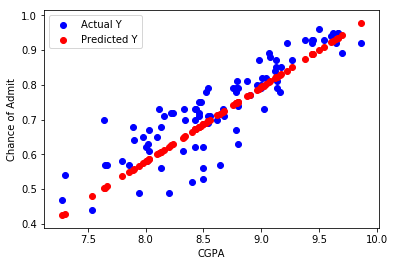

In [337]:
location = 'AdmissionDataset/data.csv'
test,train = get_test_train_with_header(location)
target = 'Chance of Admit'
slopeValues = LinearRegressionFit(test[['Serial No.','GRE Score','Chance of Admit']],train[['Serial No.','GRE Score','Chance of Admit']],target)
#GRE
X,predicted_y,r2score = predictLinear(test[['Serial No.','GRE Score','Chance of Admit']],target,slopeValues)
plt.scatter(test['GRE Score'].values,test['Chance of Admit'],c = 'b',label="Actual Y")
plt.scatter(test['GRE Score'].values,predicted_y,c='r',label="Predicted Y")

plt.xlabel("GRE Score")
plt.ylabel("Chance of Admit")
plt.legend()
plt.show()

#CGPA
slopeValues = LinearRegressionFit(test[['Serial No.','CGPA','Chance of Admit']],train[['Serial No.','CGPA','Chance of Admit']],target)

X,predicted_y,r2score = predictLinear(test[['Serial No.','CGPA','Chance of Admit']],target,slopeValues)
plt.scatter(test['CGPA'].values,test['Chance of Admit'],c = 'b',label="Actual Y")
plt.scatter(test['CGPA'].values,predicted_y,c='r',label="Predicted Y")

plt.xlabel("CGPA")
plt.ylabel("Chance of Admit")
plt.legend()
plt.show()